In [1]:
from datetime import datetime
import pandas as pd

from src.preview.emotion_preview import EmotionPreview
import csv
from pathlib import Path


In [12]:


def read_rows_from_file(saved_player_path: Path, **additional_values) -> pd.DataFrame:
    df_entries = []
    with saved_player_path.open("r") as file:
        reader = csv.reader(file)
        for date, *emotions in reader:
            for emotion_index, emotion_value in enumerate(emotions):
                entry = {
                    "date": datetime.strptime(date, '%Y-%m-%d %H:%M:%S.%f'),
                    "emotion_value": float(emotion_value),
                    "emotion_name": EmotionPreview.emotion_map[emotion_index],
                    **additional_values
                }
                df_entries.append(entry)
    return pd.DataFrame.from_dict(df_entries)

inputs = [
    ("Genshin Impact", Path("../logs/abyss.csv")),
    ("Genshin Impact", Path("../logs/abismitos.csv")),
    ("Genshin Impact", Path("../logs/ar59.csv")),
    ("Dota2", Path("../logs/lumberjack.csv")),
]

dfs = [
    read_rows_from_file(saved_player_path, streamer=saved_player_path.stem, game=game)
    for game, saved_player_path in inputs
]

for df in dfs:
    df["emotion_value"] = df["emotion_value"].astype(float)

dfs[0]

,date,emotion_value,emotion_name,streamer,game
0,2023-01-16 15:16:27.678641,2.232709e-10,neutral,abyss,Genshin Impact
1,2023-01-16 15:16:27.678641,5.115392e-01,anger,abyss,Genshin Impact
2,2023-01-16 15:16:27.678641,1.307378e-09,contempt,abyss,Genshin Impact
3,2023-01-16 15:16:27.678641,8.086491e-02,disgust,abyss,Genshin Impact
4,2023-01-16 15:16:27.678641,7.826720e-01,fear,abyss,Genshin Impact
...,...,...,...,...,...
115203,2023-01-16 15:48:45.704328,1.019654e-01,disgust,abyss,Genshin Impact
115204,2023-01-16 15:48:45.704328,9.171488e-01,fear,abyss,Genshin Impact
115205,2023-01-16 15:48:45.704328,2.271312e-02,happy,abyss,Genshin Impact
115206,2023-01-16 15:48:45.704328,1.639410e-01,sadness,abyss,Genshin Impact


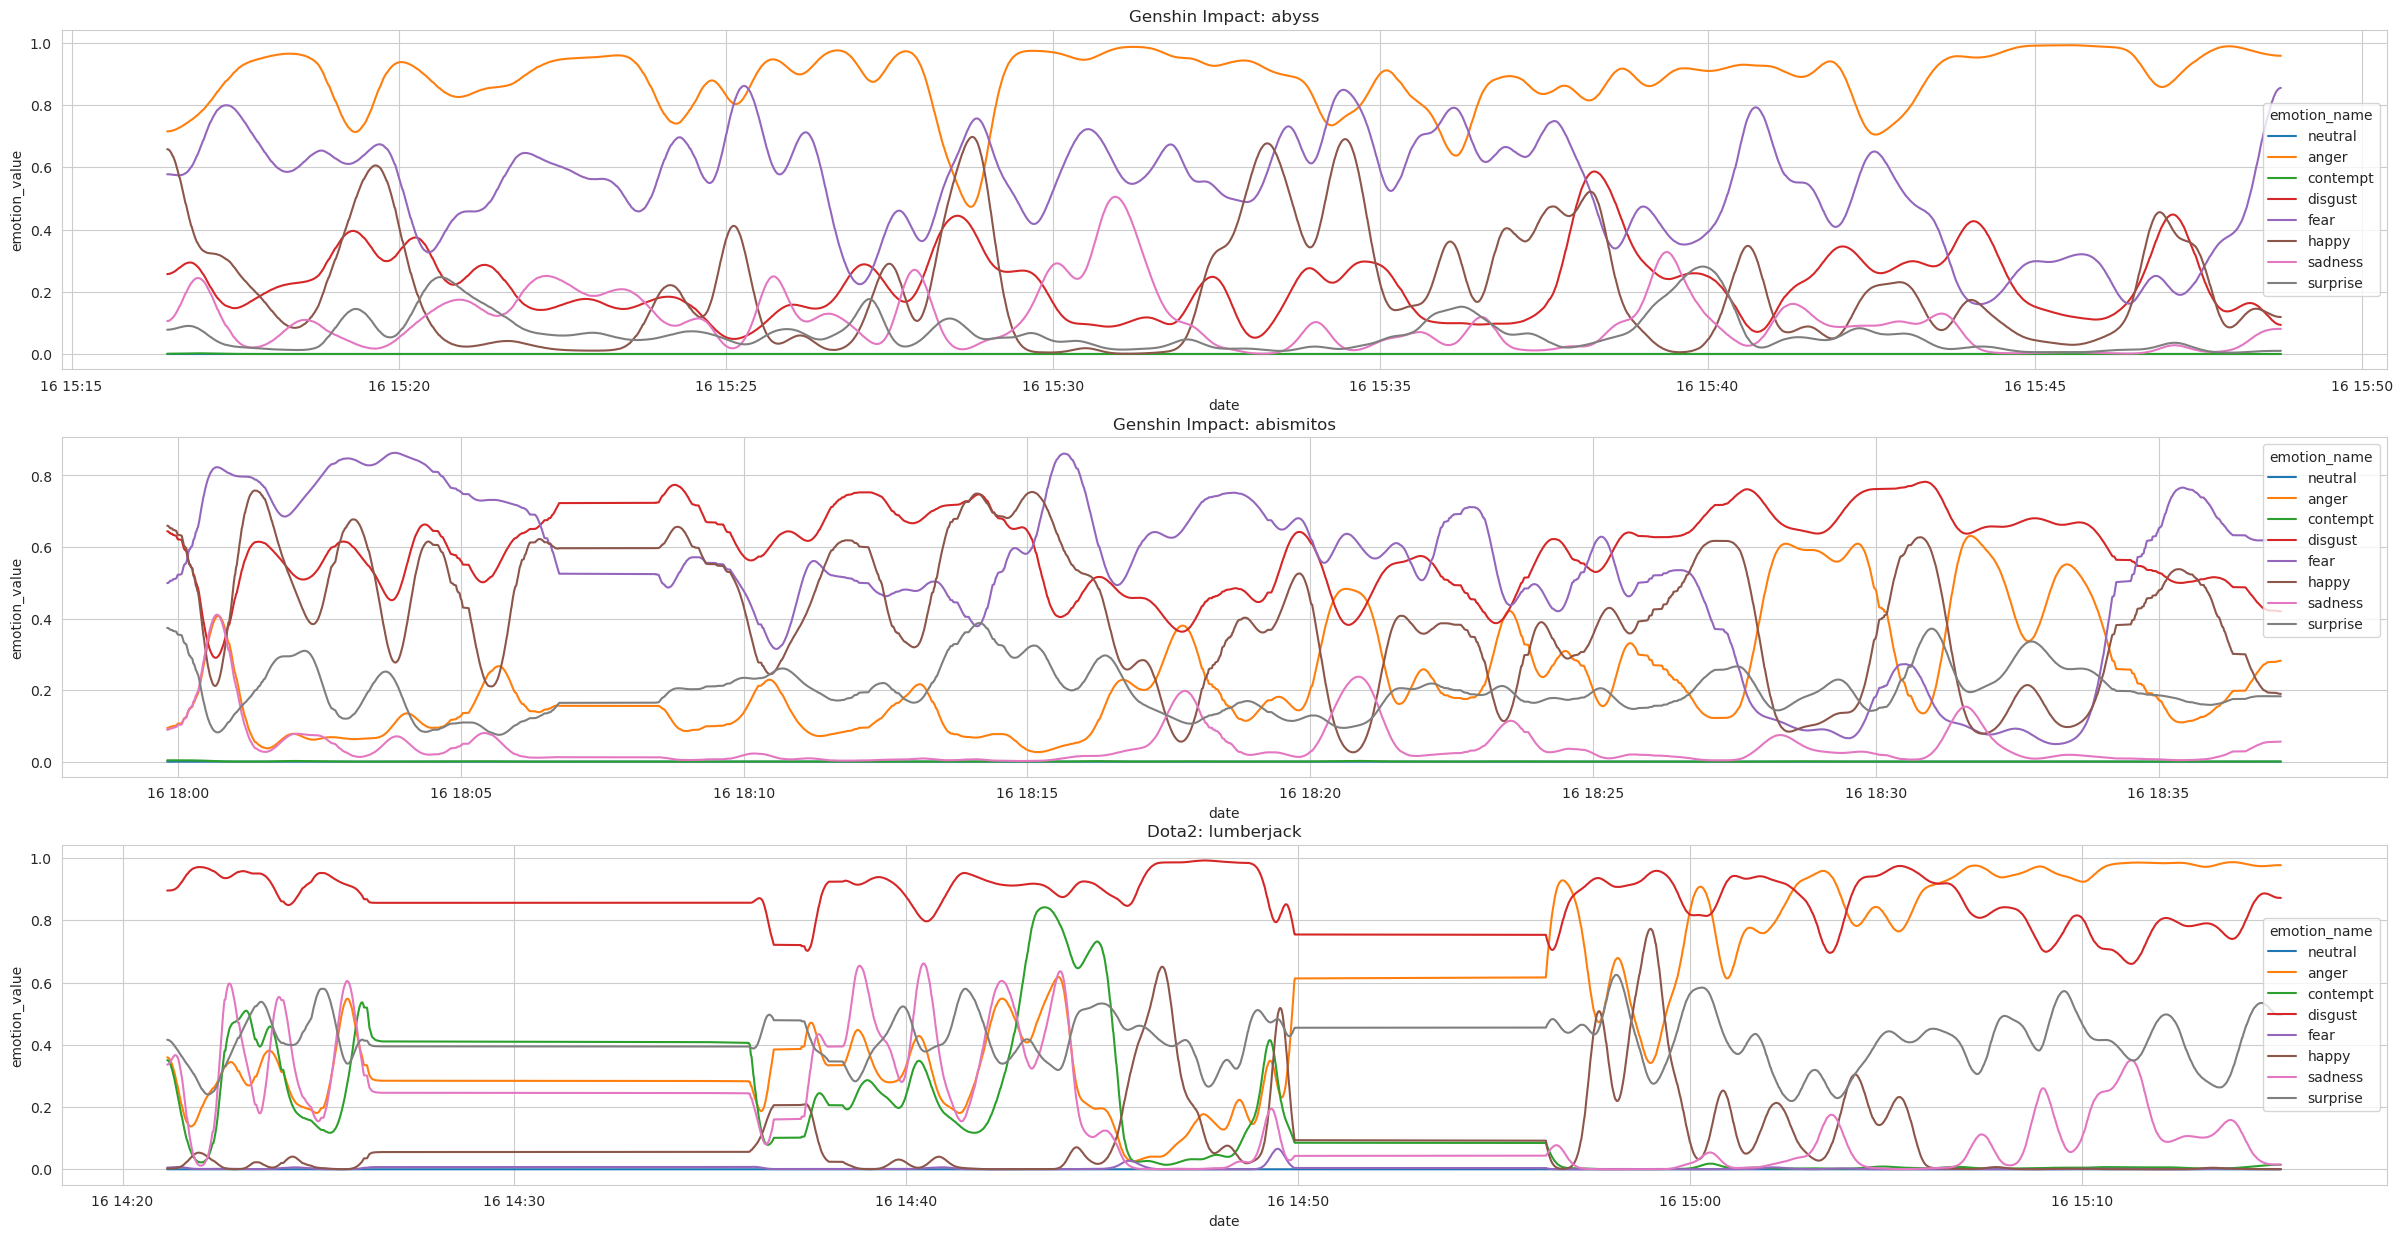

In [14]:
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.ndimage import gaussian_filter1d

def smooth_df(df):
    df_smoothed = df.copy()
    for emotion_name in df_smoothed["emotion_name"].unique():
        original = df_smoothed[df_smoothed["emotion_name"] == emotion_name]["emotion_value"]
        smoothed = gaussian_filter1d(original, sigma=100)
        df_smoothed.loc[df_smoothed["emotion_name"] == emotion_name, "emotion_value"] = smoothed
    return df_smoothed

smoothed_dfs = [smooth_df(df) for df in dfs]

fig, axs = plt.subplots(nrows=len(smoothed_dfs), figsize=(30, 5*len(smoothed_dfs)))
for smoothed_df, ax in zip(smoothed_dfs, axs):
    sns.lineplot(smoothed_df, x="date", y="emotion_value", hue="emotion_name", ax=ax)
    ax.set_title(f"{smoothed_df['game'][0]}: {smoothed_df['streamer'][0]}")
plt.show()
